Dask Approach to Non-SQL PTM Queries
--

v01: move away from classes, try to organize the computation 
primarily in dask.

In [ ]:
# There are some issues with memory usage. It seems
# (mostly based on github discussions) that with dask
# shuttling many large memory allocations around, memory
# gets fragmented and effectively lost. print_rusage()
# will report current memory usage, and the code in the
# next block changes malloc behavior to reduce 
# fragmentation.

import gc
import psutil
from distributed.utils import format_bytes
proc = psutil.Process()

def print_rusage():
    gc.collect()
    print(format_bytes(proc.memory_info().rss))
    #ru=resource.getrusage(resource.RUSAGE_SELF)
    #print(f"{ru.ru_maxrss/1000/1000.:.3f} GB maxrss")
    # That's saying that this process is using 55GB of RAM!?
    
print_rusage() # Starts 80MB

In [ ]:
from ctypes import *
libc = CDLL('libc.so.6')
mallopt = libc.mallopt
mallopt.argtypes = [c_int, c_int]
mallopt.restype = c_int
 
M_MMAP_THRESHOLD = -3
# The following would return 0 on error
mallopt(M_MMAP_THRESHOLD, 16*1024)

In [ ]:
import logging
log=logging.getLogger('postproc')

In [ ]:
try:
    client.close()
except NameError:
    pass

In [ ]:
import multiprocessing.popen_spawn_posix #  https://github.com/dask/distributed/issues/4168
import dask
import dask.dataframe as dd
import dask.bag as db

from dask.distributed import Client
client=Client(n_workers=8,threads_per_worker=1)
client.cluster

In [ ]:
import matplotlib.pyplot as plt
import conc_figure
import six
import stompy.plot.cmap as scmap
from matplotlib import cm
cmap=cm.CMRmap_r
cmap=scmap.cmap_clip(cmap,0.03,1.0)

%matplotlib notebook

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import re

from stompy.grid import unstructured_grid
from stompy import utils, memoize
from stompy.model.fish_ptm import ptm_config, ptm_tools
from stompy.model.suntans import sun_driver

import stompy.plot.cmap as scmap
turbo=scmap.load_gradient('turbo.cpt')

In [ ]:
print_rusage()

Overall Process
===

1. SUNTANS hydro runs
2. SUNTANS average output
3. ptm-formatted average output
4. PTM runs
5. Load data

The top-level query is something like *generate a map of concentrations for...*

filter on:
 - sources $x$
 - settling classes $y$
 - vertical positions $z$
 - horizontal positions $h$

weighted by

 - loading data 
 - age
 
mapped by one of ...

 - bounding box
 - put on hydro grid
 - put on regular grid

and possibly smoothed.

In [ ]:
# Experiment level configuration -- small, all python native data.
experiment=dict(
    ptm_base_dir="/opt2/sfb_ocean/ptm/all_source_022a",
    sun_base_dir="/opt2/sfb_ocean/suntans/runs",
    ptm_output_interval=np.timedelta64(1,'h')
)
experiment['ptm_run_patt']=os.path.join(experiment['ptm_base_dir'],"chunk??","20??????")
experiment['sun_patt']=os.path.join(experiment['sun_base_dir'],"merged_022_20??????")

ptm_run_paths=glob.glob(experiment['ptm_run_patt'])
ptm_run_paths.sort()

sun_paths=glob.glob(experiment['sun_patt'])
sun_paths.sort()

In [ ]:
# Load the grid into... grid
hydro_path=sun_paths[0]
ptm_ds=xr.open_dataset(os.path.join(hydro_path,"ptm_average.nc_0000.nc"))
grid=unstructured_grid.UnstructuredGrid.read_ugrid(ptm_ds,dialect='fishptm')
ptm_ds.close()   

# distribute to workers ahead of time.
grid_d=client.scatter(grid)

In [ ]:
# So far this is only used locally.  Slow to compute (15s)
Msmooth=grid.smooth_matrix()

In [ ]:
# Load data 
def get_load_data():
    """
    Load loading data, return an xr.Dataset that maps
    sources and behaviors to concentrations in particles/liter
    """
    loads_orig=xr.open_dataset("../loads/plastic_loads-7classes-v05.nc")

    # And the per-watershed scaling factor
    storm_scales=pd.read_csv("../loads/stormwater_concs-v02.csv")

    # Get rid of the extra fields in loads -- otherwise we have to fabricate
    # them for the watersheds
    loads=loads_orig.copy()

    for fld in ['n_blank_particles','n_blank_samples','blank_rate',
                'total_volume','n_samples','count_w_s','count_no_w_s',
                'conc_raw','conc_noclip','conc_blank','blank_derate']:
        del loads[fld]

    # Extend loads_orig with storm_scales
    storm_conc=loads_orig['conc'].sel(source='stormwater')
    storm_conc_net=storm_conc.values.sum()
    storm_conc_net # 8.50 particles/l

    watershed_conc=np.zeros( (len(storm_scales),loads_orig.dims['category'],loads_orig.dims['w_s']))
    # bui(source, category, w_s) 
    for storm_i,storm_scale in storm_scales.iterrows():
        watershed_conc[storm_i,:,:] = storm_conc.values * storm_scale['net_coeff_scaled'] / storm_conc_net

    watershed_loads=xr.Dataset()
    watershed_loads['source']=('source',),storm_scales['source']
    watershed_loads['conc']=('source','category','w_s'),watershed_conc
    watershed_loads['source_pathway']=('source',),['stormwater']*len(storm_scales)
    watershed_loads['pathway']=loads_orig['pathway']

    loads=xr.concat( (loads,watershed_loads), dim='source')

    # drop 'stormwater' to catch potential bugs later
    return loads.isel(source=(loads.source!='stormwater'))

# Or could make this delayed and have it execute on each client?
load_data_d=client.scatter(get_load_data())

# Static data from Group
w_s_map={'down50000':0.05,
         'down5000':0.005,
         'down500':0.0005,
         'none':0.0,
         'up500':0.0005,
         'up5000':0.005,
         'up50000':0.05}
# For a subset of the source names in the PTM setup,
# map them to the name used in the loading data
source_ptm_to_load={
    'cccsd':'CCCSD',
    'sunnyvale':'SUNN',
    'fs':'FSSD',
    'palo_alto':'PA',
    'san_jose':'SJ',
    'src000':'EBDA',
    'src001':'EBMUD',
    'src002':'SFPUC',
    # These shouldn't be used, but including just to be sure
    # that if they somehow show up, they won't contaminate
    # stormwater.
    'SacRiver':'DELTA',
    'SJRiver':'DELTA'
}

In [74]:
def total_area(g):
    return g.cells_area().sum()

total_area_d=dask.delayed(total_area)(grid_d)

In [75]:
# Hydro timestamps
N=len(sun_paths)
hydro_timestamps=np.zeros((N,2), "<M8[ns]") 

def sun_path_to_hydro(sun_path):
    return os.path.join(sun_path,"ptm_average.nc_0000.nc")

def open_hydro_ds(self,idx):
    return xr.open_dataset()

for run_idx in range(N):
    ds=xr.open_dataset(sun_path_to_hydro(sun_paths[run_idx]))
    t=ds.Mesh2_data_time
    hydro_timestamps[run_idx,0]=t.values[0]
    hydro_timestamps[run_idx,1]=t.values[-1]
    ds.close()

In [76]:
def extract_bc_ds(compiled_fn):
    dss=[]
    dss_orig=[] # for closing

    for run_path in sun_paths:
        # only care about point sources, and river inflows (i.e. ignore
        # ocean flux BCs, and any freesurface BCs
        model=sun_driver.SuntansModel.load(run_path)
        ds=model.load_bc_ds()
        dss_orig.append(ds)
        ti_start,ti_stop=np.searchsorted(ds.time.values,[model.run_start,model.run_stop])
        ds=ds.isel(Nt=slice(ti_start,ti_stop+1))

        for extra in ['T','S','h','boundary_h','boundary_w','boundary_T',
                      'boundary_u','boundary_v','z',
                      'point_S','point_T','cellp','xv','yv','uc','vc','wc']:
            if extra in ds: del ds[extra]

        type2_sel= ds['boundary_S'].isel(Nk=0,Nt=0)==0.0
        ds=ds.isel(Ntype2=type2_sel)
        del ds['boundary_S']
        dss.append(ds)

    trim_dss=[]
    for ds in dss:
        if not trim_dss:
            trim_dss.append(ds)
            continue
        else:
            t_sel=ds.time.values>trim_dss[-1].time.values[-1]
            if t_sel.sum():
                trim_dss.append(ds.isel(Nt=t_sel))
            else:
                log.warning("BC dataset had no useful times?")

    assert len(trim_dss)
    ds=xr.concat(trim_dss,dim='Nt',data_vars='different')
    # somehow there is some 1e-9 difference between xe 
    for v in ['xe','ye']:
        if 'Nt' not in ds[v].dims: continue
        # make sure it's not a terrible issue
        assert ds[v].std(dim='Nt').max()<1.0
        ds[v]=ds[v].isel(Nt=0)

    # A bit goofy, but try to avoid a race condition, short of
    # utilizing a real lock.
    tmp_fn=compiled_fn+"."+str(os.getpid())
    ds.to_netcdf(tmp_fn)
    if not os.path.exists(compiled_fn):
        os.rename(tmp_fn,compiled_fn)
    else:
        log.warning("Things got racy while transcribing BC data")
        os.unlink(tmp_fn)

    [ds.close() for ds in dss_orig]
    

def bc_ds():
    """ Extract the relevant parts of the BC data, return as a single dataset
    """
    compiled_fn=os.path.join(sun_paths[0],'bc_extracted_v4.nc')

    if not os.path.exists(compiled_fn):
        extract_bc_ds(compiled_fn)
    ds=xr.open_dataset(compiled_fn)
    return ds

bc_ds_d=client.scatter(bc_ds())

In [77]:
def source_Qdata(source,bc_ds):
    """
    returns a time series DataArray for the
    respective source's flow rate.
    This step also clamps flows to be non-negative.
    """
    # get a flow time series for this specific group
    try:
        seg_i=list(bc_ds.seg_name.values).index(source)
        Q_time_series=bc_ds.set_coords('time')['boundary_Q'].isel(Nseg=seg_i)
    except ValueError:
        # point sources are labeled as srcNNN
        pnt_i=int(source.replace('src',''))
        Q_time_series=bc_ds.set_coords('time')['point_Q'].isel(Npoint=pnt_i)

    return Q_time_series.clip(0.0)

In [78]:
# Criteria need to get mapped to runs

def run_to_group_paths(run_path):
    group_paths=glob.glob(os.path.join(run_path,"*_bin.out"))
    group_paths.sort() # nice, but not necessary
    return group_paths

def parse_group_path(p):
    m=re.match(r'(.*)_((up|down|none)\d*)_rel(\d+)_bin.out',os.path.basename(p))
    if m is None:
        raise Exception(f"Failed to parse p={p}")
    source,behavior,release_date=m.group(1),m.group(2),m.group(3)
    return source,behavior,release_date

In [79]:
def criteria_to_groups(criteria):
    # criteria dictionary => list of bin files.
    group_paths=[]
    
    for run_path in ptm_run_paths:
        run_group_paths=run_to_group_paths(run_path)
        group0_path=run_group_paths[0]
        pb=ptm_tools.PtmBin(fn=group0_path)

        t_min=pb.time[0]
        t_max=pb.time[-1]
        
        # "Minimum time of particle outputs."
        # relies on knowing that all groups follow the same start/end 
        # within a run
        
        if 't_min' in criteria and t_max<criteria['t_min']:
            continue
        if 't_max' in criteria and t_min>criteria['t_max']:
            continue

        if ('age_max' in criteria) and ('t_min' in criteria):
            # May also be able to narrow on the range of release times,
            # These are also the same over all groups within a run.
            rel_log_fn=group0_path.replace('_bin.out','.release_log')
            release_log=ptm_tools.ReleaseLog(rel_log_fn)
            rel_t_max=release_log.data.date_time.max()
            run_age_min=criteria['t_min']-rel_t_max
            if run_age_min>criteria['age_max']:
                # The time between the last release and the start 
                # of the requested period is greater than the
                # max age for the query. Skip it.
                continue
            
        if 'behavior' in criteria:
            select_groups=[]
            for gp in run_group_paths:
                source,behavior,rel_date=parse_group_path(gp)
                if behavior not in criteria['behaviors']: 
                    continue
                select_groups.append(gp)
            run_groups_paths=select_groups
        group_paths+=run_group_paths

    return group_paths
        

In [80]:
# Helpers for group-level calculation.
def load_conc(source,behavior,criteria,load_data):
    """
    Concentration for this particle group, in particles/liter.
    categories: 'all','nonfiber', a list of category names,
    or a single category name
    """
    categories=criteria.get('category','all')
    
    # source: e.g. 'San_Lorenzo_C'.
    # Remaps a subset of the source names
    load_source=source_ptm_to_load.get(source,source)
    w_s=w_s_map[behavior]
    conc_over_category=load_data['conc'].sel(source=load_source,w_s=w_s)
    if categories=='all':
        conc=conc_over_category.values.sum()
    elif categories=='nonfiber':
        sel=conc_over_category.category!='Fiber'
        conc=conc_over_category.isel(category=sel).values.sum()
    else:
        conc=conc_over_category.sel(category=categories).values.sum()
    return conc


In [81]:

def volume_per_particle(particles,rel,source,bc_ds):
    """
    Need particles/per time for release time t
    and volume/time for source at time t.
    Returns array with volume per particle for each of the given particles.

    particles: dataframe with rel_time per particle.
    rel: ptm_tools.ReleaseLog instance.
    
    Some parts of this aren't really group specific, could be moved elsewhere.
    """
    # Sanity check:
    # this is giving about 60m3/particle.
    # I know there are 10 particles/hr released.
    # so that's saying that San_Lorenzo_C[reek] has
    # a flow of 600m3/hour, or 0.17 m3/s in June 2017.
    # USGS measured is 6-8 cfs, which is order 0.2 m3/s.
    # Good.

    # Record the data from release_log
    release=rel.intervals

    # Ham-handed fix up of truncated release logs.
    typical_count=int( np.median( release['count'] ) )
    bad=release['count']!=typical_count
    assert not np.any(bad),"May need to add back the bandaid"
    # a little bit smart -- only step in when it's the last step that's
    # different.
    # if (not np.any(bad[:-1])) and bad[-1]:
    #     print("Yikes - release_log might be missing some particles.")
    #     print("  Changing reported count of %d to %d"%(release['count'].values[-1],
    #                                                    typical_count))
    #     print("  And punting on id_max,gid_max")
    #     release.loc[bad,'count']=typical_count
    #     # careful of inclusive indexes
    #     release.loc[bad,'id_max']=release.loc[bad,'id_min']+typical_count-1
    #     release.loc[bad,'gid_max']=release.loc[bad,'gid_min']+typical_count-1

    # add in volume information.
    Qdata=source_Qdata(source,bc_ds)
    Qvalues=Qdata.values
    Qpart=np.zeros(len(particles),np.float64)
    Qpart[:]=np.nan # for safety

    for t,part_idxs in utils.enumerate_groups(particles['rel_time'].values):
        Qidx=np.searchsorted(Qdata.time.values,t)
        Qpart[part_idxs]=Qvalues[Qidx]

    grp_hour_per_rel=(release['time'].values[1] - release['time'].values[0])/np.timedelta64(3600,'s')

    # m3/s * s/hour * hour/release / (particles/release) => m3/particle
    part_volume=Qpart*3600 * grp_hour_per_rel/typical_count
    return part_volume # m3/particle


In [113]:
# Query particles from a group satisfying criteria
# I don't think I want to put particles on the grid here,
# since that step benefits from having large chunks of
# particles.
# This is a good time to add particle weight data, since
# that is calculated on a group and time level.

def query_group_particles(group_path,criteria,load_data,bc_ds):
    """
    Create a pd.DataFrame of particles from this group
    that satisfy criteria.
    """
    def empty():
        # a request for a metadata frame or if no data found
        # While it looks like this creates a dataframe with
        # one row of dummy data, it seems that, by virtue of
        # these not being sequences, this actually creates
        # an empty dataframe with the corresponding types.
        df=pd.DataFrame()
        df['id']=np.int32(1)
        df['x0']=np.float64(2.0)
        df['x1']=np.float64(3.0)
        df['x2']=np.float64(4.0)
        df['active']=np.int32(5)
        df['time']=np.datetime64("2000-01-01") # will there be trouble?
        df['group']="a-path-string"
        df['rel_time']=np.datetime64("2000-01-01")
        df['mp_per_liter']=np.float64(1.0)
        df['m3_per_particle']=np.float64(2.0)
        df['mp_per_particle']=np.float64(3.0)
        return df

    if group_path is None: 
        return empty()
    
    run_path=os.path.dirname(group_path)
    source,behavior,rel_date=parse_group_path(group_path)
    
    pbf=ptm_tools.PtmBin(group_path)
    times=np.array( [utils.to_dt64(t) for t in pbf.time] )

    sel=np.ones(len(times),np.bool8) # bitmask of which output steps to include
    if 't_min' in criteria:
        sel=sel&(times>=criteria['t_min'])
    if 't_max' in criteria:
        sel=sel&(times<=criteria['t_max'])

    all_particles=[]
    for ts in np.nonzero(sel)[0]:
        datenum,particles=pbf.read_timestep(ts)
        if 'bbox' in criteria:
            sel=( (particles['x'][:,0]>=bbox[0]) &
                  (particles['x'][:,0]< bbox[1]) &
                  (particles['x'][:,1]>=bbox[2]) &
                  (particles['x'][:,1]< bbox[3]))
            if not np.any(sel):
                del particles # let memmap'd data return to dust
                continue
            else:
                particles=particles[sel]
        t=utils.to_dt64(datenum)
        df=pd.DataFrame()
        df['id']=particles['id']
        df['x0']=particles['x'][:,0]
        df['x1']=particles['x'][:,1]
        df['x2']=particles['x'][:,2]
        df['active']=particles['active']
        # Avoid keeping all this memmap'd data around
        del particles
        df['time']=t
        all_particles.append(df)
    if len(all_particles):
        df=pd.concat(all_particles)
        df['group']=group_path

        # Assign release times
        # If this is slow, could verify that release_log index 
        # is dense, and do this in numpy
        rel_log_fn=group_path.replace('_bin.out','.release_log')
        release_log=ptm_tools.ReleaseLog(rel_log_fn) # used below
        df_rel=release_log.data.set_index('id') # id vs gid?
        rel_times=df_rel.loc[ df['id'].values,'date_time']
        df['rel_time']=rel_times.values

        if 'age_max' in criteria:
            sel = (df['time']-df['rel_time']) < criteria['age_max']
            if np.any(sel):
                df=df[sel].copy() # otherwise further operations will error
            else:
                return empty()

        # Associating numerical particles with load particles
        mp_per_liter=load_conc(source,behavior,criteria,load_data)

        df['mp_per_liter']=mp_per_liter
        # self.add_mp_count(df,criteria)
        # how many m3 of effluent does each computational particle
        # represent?
        m3_per_particle=volume_per_particle(df,release_log,source,bc_ds)
        df['m3_per_particle']=m3_per_particle
        
        #                  mp_count / m3   *   m3 / particle
        mp_per_particle=mp_per_liter * 1e3 * m3_per_particle
        df['mp_per_particle']=mp_per_particle
        
        if len(df):
            return df
        else:
            # maybe?
            return empty()
    else:
        return empty()


In [114]:
def get_z_surface(p_time,p_cell):
    """
    p_time: array of timestamps (datetime64)
    p_cell: array of grid cell index
  
    return array with the elevation of the
    water surface at the particle time, linearly interpolated.

    It is possible but rare for particle['z'] values to be
    above z_surface (and below z_bed) but so far this does not
    appear to be a bug in this code. Rather, the cell mapping
    code is approximate when a point is not clearly within any
    cell polygon.  And in a few cases it appears the particle
    isn't in the domain.
    """
    p_order=np.argsort(p_time)
    p_order_time=p_time[p_order]
    p_order_cell=p_cell[p_order]

    t_min=p_order_time[0]
    t_max=p_order_time[-1]

    N=hydro_timestamps.shape[0]
    def t_to_idx(t):
        # search on ending to avoid one-off correction.
        idx=np.searchsorted(hydro_timestamps[:,1],t).clip(0,N-1)
        if t<hydro_timestamps[idx,0] or t>hydro_timestamps[idx,1]:
            idx=9999999999 # force bounds issue
        return idx
    idx0,idxN=t_to_idx(t_min),t_to_idx(t_max)

    # hold the results, constructed in time order
    p_order_eta=np.nan*np.zeros(len(p_time),np.float32)

    def extract_eta(ds,p_time,p_cell):
        """
        ds: dataset for a chunk of a hydro run
        p_time: times, must fall within ds
        p_cell: cells corresponding to the particle times

        returns: eta values interpolated from ds at the given times, and
        extracted for the given cells.
        """
        ds_time=ds.Mesh2_data_time.values
        p_eta=np.nan*np.ones(len(p_time))
        # waterlevel is instantaneous, and we can linearly interpolate
        # between timesteps. Particles are output at 0.25h or 0.5h intervals,
        # so it doesn't take too many different interpolations.
        for t_grp,part_idxs in utils.progress(utils.enumerate_groups(p_time)):
            tA=ds_time.searchsorted(t_grp)
            assert tA<len(ds_time),"Seems to step off the end of the data"
            # For an exact match, tA is the step we want.
            if ds_time[tA]==t_grp: # good
                eta=ds.Mesh2_sea_surface_elevation.isel(nMesh2_data_time=tA).values
            else:
                # Linearly interpolate:
                assert tA+1<len(ds_time)
                etaA=ds.Mesh2_sea_surface_elevation.isel(nMesh2_data_time=tA).values
                etaB=ds.Mesh2_sea_surface_elevation.isel(nMesh2_data_time=tA+1).values
                theta=(t_grp-ds_time[tA])/(ds_time[tA+1] - ds_time[tA])
                assert theta>=0
                assert theta<=1.0
                eta=(1-theta)*etaA[0,:] + theta*etaB
            p_eta[part_idxs]=eta[p_cell[part_idxs]]
        return p_eta

    for idx in range(idx0,idxN+1):
        # Iterate over hydro runs
        hyd_t_start,hyd_t_stop=hydro_timestamps[idx]

        # Edge cases?
        #  for particles times [x,x,x,y,y,y,z,z,z]
        #  and idx_start=x, idx_stop=z
        #  particle time falls on the first step of output:
        #  then order_start will 
        order_start=p_order_time.searchsorted(hyd_t_start,side='left')
        order_stop =p_order_time.searchsorted(hyd_t_stop,side='right')
        if order_start==order_stop:
            continue # empty slice

        part_slc=slice(order_start,order_stop)
        assert np.all( p_order_time[part_slc]>=hyd_t_start )
        assert np.all( p_order_time[part_slc]<=hyd_t_stop  )

        ds=xr.open_dataset(os.path.join(sun_paths[idx],"ptm_average.nc_0000.nc"))

        eta_slc=extract_eta(ds,
                            p_order_time[part_slc],
                            p_order_cell[part_slc])
        p_order_eta[part_slc]=eta_slc
        ds.close()
    assert np.all(np.isfinite(p_order_eta))
    # Undo the sort to assign back to the particles:
    z_surface=p_order_eta[np.argsort(p_order)]
    return z_surface

In [115]:
# particle attributse (cell, z coordinate)
# we run at the partition level (and maybe after
# repartitioning)
# First, just deal with computing these fields, putting them into
# a parallel dataframe.

# @dask.delayed(pure=True)
def get_particle_attrs(particles,grid,inplace=False,fallback=True):
    """
    Calculate a pd.dataframe with cell, z_bed, z_surface from given particles.
    particles should be a pandas dataframe (not dask).
    Copies particles and adds the new columns
    """
    if not inplace:
        # or could make a second dataframe just sharing index?
        particles=particles.copy()
        
    if len(particles)==0:
        return particles # get_z_surface fails on empty input
    
    pnts=particles[['x0','x1']].values
    cell=grid.points_to_cells(pnts)
    if fallback:
        missing=(cell<0)
        log.info("%d/%d cells not found on first try"%(missing.sum(),len(missing)))
        cell[missing]=grid.points_to_cells(pnts[missing],method='cells_nearest')
                
    particles['cell']=cell
    particles['z_bed']=grid.cells['z_bed'][cell]
    particles['z_surface']=get_z_surface(particles['time'].values,cell)
    
    age_s=(particles['time']-particles['rel_time'])/np.timedelta64(1,'s')
    particles['age_s']=age_s
    return particles

meta=query_group_particles(None,None,None,None)
meta['cell']=np.int32(1)
meta['z_bed']=np.float64(1.0)
meta['z_surface']=np.float64(2.0)
meta['age_s']=np.float64(3.0)

get_particle_attrs.meta=meta

In [116]:
def query_particles_with_attrs(criteria):
    """
    Takes a criteria dictionary and returns an
    uncomputed dask dataframe with particles satisfying
    the criteria
    Includes particle counts scaled from loads, relative
    z coordinates.
    """

    # Warm start more like 2s.  Not worth dask-ing yet.
    groups=criteria_to_groups(criteria)

    # Following the suggestion here: https://github.com/dask/dask/issues/1680
    reader=dask.delayed(query_group_particles,pure=True) # I think it's pure

    group_data_d=[reader(grp_fn,criteria,load_data_d,bc_ds_d)
                  for grp_fn in groups]

    parts_d=dd.from_delayed(group_data_d,
                            meta=query_group_particles(None,criteria,None,None))

    # This is working.  But it's not super fast with many partitions
    # repartition to 20 gets that down to 37s.
    # repartition to 40 is 40s.
    # repartition to 8 ... ? 60s.
    # repartition to 30MB => 1m10 (and 180 partitions)
    # repartition to 150MB => 50s (and 30 partitions)
    # How does this scale?  All those numbers are with 8 workers.
    # 16 workers=>30s. Not amazing strong scaling. Maybe we get
    # weak scaling, though.

    # fine for smaller jobs
    ngrps=len(grps)
    if ('t_max' in criteria) and ('t_min') in criteria:
        dt=(criteria['t_max']-criteria['t_min'])
    else:
        dt=np.timedelta64(60,'D')
    n_output_steps=dt/np.timedelta64(1,'h')
    # empirical estimate.
    npartitions=max(1,int(len(grps)*n_output_steps / 300.0))
    print(f"Will repartition with {npartitions} partitions")
    repart=parts_d.repartition(npartitions=npartitions)
    # For larger jobs, try auto scaling by size:
    #repart=parts_d.repartition(partition_size="150MB")
    part_attrs_d=repart.map_partitions(get_particle_attrs,grid_d,
                                       meta=get_particle_attrs.meta)
    return part_attrs_d

def filter_particles_post_attrs(particles, criteria):
    """ Return a subset of particles that satisfy additional criteria
    of z_below_surface, z_above_bed, and age_max.
    particles: dask or pandas dataframe.
    """
    # Can now filter on z
    part_filtered=particles
    if 'z_below_surface_max' in criteria:
        sel=(part_filtered['z_surface']-part_filtered['x2'])<criteria['z_below_surface_max']
        part_filtered=part_filtered[sel]
    if 'z_above_bed_max' in criteria:
        sel=(part_filtered['x2']-part_filtered['z_bed'])<criteria['z_above_bed_max']
        part_filtered=part_filtered[sel]
    if 'age_max' in criteria:
        age_max_s=criteria['age_max']/np.timedelta64(1,'s')
        sel=(part_filtered['age_s']<=age_max_s)
        part_filtered=part_filtered[sel]
    return part_filtered

def query_particles(criteria):
    part_attrs_d=query_particles_with_attrs(criteria)
    part_filtered=filter_particles_post_attrs(part_attrs_d,criteria)
    return part_filtered

In [101]:
criteria=dict(t_min=np.datetime64("2017-06-30 00:00"), # should be 08/30
              t_max=np.datetime64("2017-07-01 00:00"), # should be 09/14
              category='nonfiber',
              z_below_surface_max=0.095,
              age_max=np.timedelta64(10,'D'))

#particles=query_particles(criteria).compute()

In [87]:
#particles.head()

In [88]:
# Particle->grid mapping code
def particles_to_conc(particles,grid,
                      count_field='mp_per_particle',
                      scale=1.0,smooth=0):
    """
    sum particles counts (weights) per cell. Any aging or scaling
    should be done by the caller, and point to the resulting particle
    field in 'count_field'
    Note that this just sums the counts, applying an optional scaling.
    When particles covers multiple time steps of output, the caller
    should probably provide a suitable scaling to average in time.

    Returns xr.Dataset
    """
    mp_counts=particles.groupby('cell')[count_field].sum()

    cell_counts=np.zeros(grid.Ncells(),np.float64)
    cell_counts[mp_counts.index.values] = mp_counts.values
    cell_conc=cell_counts/grid.cells_area()
    for _ in range(smooth):
        cell_conc=Msmooth.dot(cell_conc)

    cell_conc*=scale 

    ds=xr.Dataset()
    ds['conc']=('cell',),cell_conc
    return ds
        

In [89]:
def query_particle_concentration(criteria,decay=None):
    """
    Map particles, with optional decay function, onto grid 
    as concentrations. Returns xr.Dataset suitable for BayConcFigure.
    """
    # First, take a sequential approach, time it, then come back
    # to push more postprocessing out to nodes.
    
    # For long-ish time periods this runs into serious memory issues.
    print("Query particles")
    parts=query_particles(criteria=criteria)
    print("Computing...")
    particles=parts.compute()
    print(f"Compute done. {len(particles)} particles")
 
    age_s=particles['age_s'].values
    age_max=criteria.get('age_max', np.timedelta64(60,'D'))
    age_max_s=age_max/np.timedelta64(1,'s')
    weights=np.where( age_s<age_max_s,1.0,0.0)
    
    if decay is not None:
        decay_s=decay/np.timedelta64(1,'s')
        weights*=np.exp(-age_s/tau_s)
        
    particles['weighted_count']=weights*particles['mp_per_particle'].values
    
    output_steps=1+int( (criteria['t_max'] - criteria['t_min'])/experiment['ptm_output_interval'])
    scale=1./output_steps
    
    ds=particles_to_conc(particles,grid,smooth=0,scale=scale,
                         count_field='weighted_count')

    ds['conc'].attrs['grp_filter']=criteria.get('behavior','')
    ds['criteria']=(),criteria
    
    # Manual determination of name of z_filter
    z_filters=[]
    if 'z_below_surface_max' in criteria:
        z_filters.append("surface %.3f"%criteria['z_below_surface_max'])
    if 'z_above_bed_max' in criteria:
        z_filters.append("bed %.3f"%criteria['z_above_bed_max'])
    
    ds['conc'].attrs['z_filter']=" and ".join(z_filters)
    ds['conc'].attrs['t_start']=criteria['t_min']
    ds['conc'].attrs['t_stop']=criteria['t_max']
    ds['conc'].attrs['max_age']=age_max
    ds['conc'].attrs['scale']=scale
    ds['conc'].attrs['output_steps']=output_steps
    
    return ds

In [90]:
%%time
if 0:
    # This takes 40s or so.
    criteria=dict(t_min=np.datetime64("2017-06-30 00:00"), # should be 08/30
                  t_max=np.datetime64("2017-07-01 00:00"), # should be 09/14
                  category='nonfiber',
                  z_below_surface_max=0.095,
                  age_max=np.timedelta64(10,'D'))
if 1:
    # For 2 days, takes 2m17
    # Had to dial down the size.  With partition size of 30MB
    # this takes 50 minutes.
    # With a 150MB partition size, and some prefiltering based on age_max,
    # This is down to 13m42.
    criteria=dict(t_min=np.datetime64("2017-08-30 00:00"), # should be 08/30
                  t_max=np.datetime64("2017-09-14 00:00"), # should be 09/14
                  category='nonfiber',
                  z_below_surface_max=0.095,
                  age_max=np.timedelta64(10,'D'))


conc_ds=query_particle_concentration(criteria=criteria,
                                     decay=None)

Query particles
Computing...
Compute done. 46591152 particles
CPU times: user 1min 25s, sys: 19.6 s, total: 1min 45s
Wall time: 13min 42s


INFO:join_features:0 open strings, 25 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=38109911619.298943, 24 potential interiors


<IPython.core.display.Javascript object>


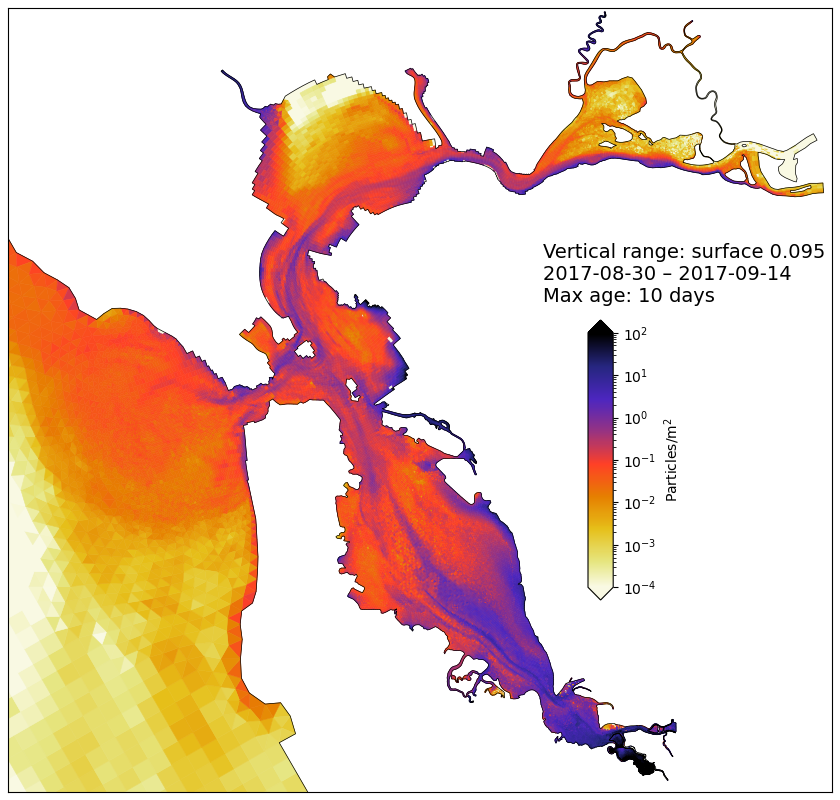

In [93]:
six.moves.reload_module(conc_figure)

conc_figure.BayConcFigure(conc_ds,grid=grid,cmap=cmap)

Next steps
--


1. Recreate some of the figures from before, including on-grid smoothing.  
  a. Sample plot: from the powerpoint. 2017-08-30 to 2017-09-14. Surface particles
     max age of 10 days.   *This plot is similarish -- not exactly the same but close
     enough to rule out fundamental errors*
2. Pull out manta samples as before. Maybe skip putting it on the grid, just
   query a radius.
  a. Implement in this notebook
  b. Move all of this to a module.

In [120]:
%%time

# time has increased to 1m11, due to memory test on repartition.
# With an empirical calculation of partition count, that's down to 43s.
# With a small bounding box, it's 14s with age_max=10D
# 

criteria=dict(t_min=np.datetime64("2017-11-30 00:00"), 
              t_max=np.datetime64("2017-12-01 00:00"), 
              category='nonfiber',
              # query a 1km x 1km box
              bbox=[563000,564000,4166000,4167000],
              z_below_surface_max=0.095,
              age_max=np.timedelta64(60,'D'))

part_d=query_particles(criteria=criteria)
df=part_d.compute()
df

Will repartition with 54 partitions
CPU times: user 32.9 s, sys: 2.66 s, total: 35.6 s
Wall time: 2min 6s


,id,x0,x1,x2,active,time,group,rel_time,mp_per_liter,m3_per_particle,mp_per_particle,cell,z_bed,z_surface,age_s
3,2093,563128.454957,4.166717e+06,-4.785490,1,2017-11-30 11:00:00,/opt2/sfb_ocean/ptm/all_source_022a/chunk00/20...,2017-10-06 17:00:00,0.001504,45.524995,68.454095,38120,-10.915180,-4.741178,4730400.0
1,2361,563155.785824,4.166112e+06,-5.060159,1,2017-11-30 23:00:00,/opt2/sfb_ocean/ptm/all_source_022a/chunk00/20...,2017-10-07 20:00:00,0.001504,41.319943,62.131128,38173,-9.312405,-4.976075,4676400.0
3,1881,563731.340984,4.166535e+06,-4.798832,1,2017-11-30 11:00:00,/opt2/sfb_ocean/ptm/all_source_022a/chunk00/20...,2017-10-05 20:00:00,0.002336,239.390625,559.327153,38176,-10.915180,-4.744245,4806000.0
7,1496,563749.303951,4.166429e+06,-3.106768,1,2017-11-30 16:00:00,/opt2/sfb_ocean/ptm/all_source_022a/chunk00/20...,2017-10-04 05:00:00,0.042645,218.662693,9324.873254,38203,-10.915180,-3.021257,4964400.0
2,1130,563154.226533,4.166421e+06,-4.764422,1,2017-11-30 22:00:00,/opt2/sfb_ocean/ptm/all_source_022a/chunk00/20...,2017-10-02 16:00:00,0.042645,197.425057,8419.194033,38147,-10.915180,-4.673637,5119200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,507,563525.119378,4.166096e+06,-3.458675,1,2017-11-30 06:00:00,/opt2/sfb_ocean/ptm/all_source_022a/chunk03/20...,2017-11-09 02:00:00,0.003056,1.530956,4.679044,38201,-9.312405,-3.449946,1828800.0
0,1537,563028.634891,4.166126e+06,-4.453649,1,2017-11-30 09:00:00,/opt2/sfb_ocean/ptm/all_source_022a/chunk03/20...,2017-11-13 09:00:00,0.003056,0.677336,2.070135,38172,-7.887712,-4.420975,1468800.0
0,34,563558.830717,4.166470e+06,-3.090541,1,2017-11-30 16:00:00,/opt2/sfb_ocean/ptm/all_source_022a/chunk03/20...,2017-11-07 03:00:00,0.266251,4.577758,1218.834653,38175,-10.915180,-3.021249,2034000.0
1,158,563315.486999,4.166612e+06,-5.168948,1,2017-12-01 00:00:00,/opt2/sfb_ocean/ptm/all_source_022a/chunk03/20...,2017-11-07 15:00:00,0.106114,0.780480,82.819975,38148,-10.915180,-5.108605,2019600.0


In [111]:
bbox=criteria['bbox']
sel=(df['x0']>=bbox[0])&(df['x0']<bbox[1])
sel=sel & (df['x1']>=bbox[2])&(df['x1']<bbox[3])
df_bbox=df[sel] # 258 particles.

In [112]:
len(df_bbox)

258